In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic


from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

from torchvision.transforms.functional import rotate
import torch.nn.functional as F

In [2]:
# Code for regression part is modified from code from "universal functional regression with neural operator flows"

n_x = 64
dims = [n_x, n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/blackhole')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22)

modes = 32 # previous 32 # can be applied to 32x32, or 128x128
width = 128
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

In [4]:
x_raw = np.load('bh_all.npy')
x_raw = torch.Tensor(x_raw).unsqueeze(1)
x_train = x_raw[:-100] + 1e-8
x_test = x_raw[-100:] + 1e-8

## load trained model

In [6]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [7]:
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

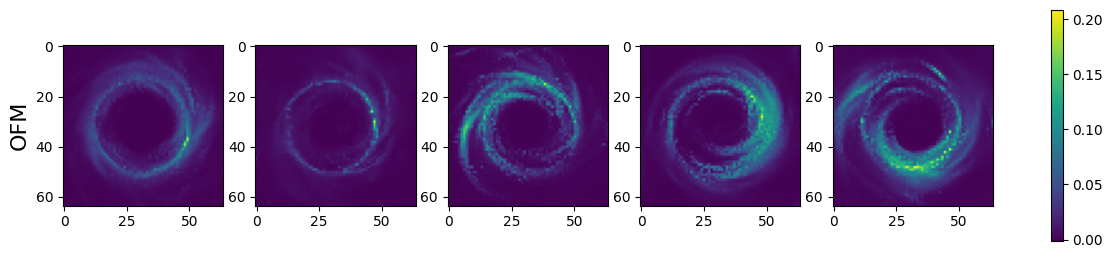

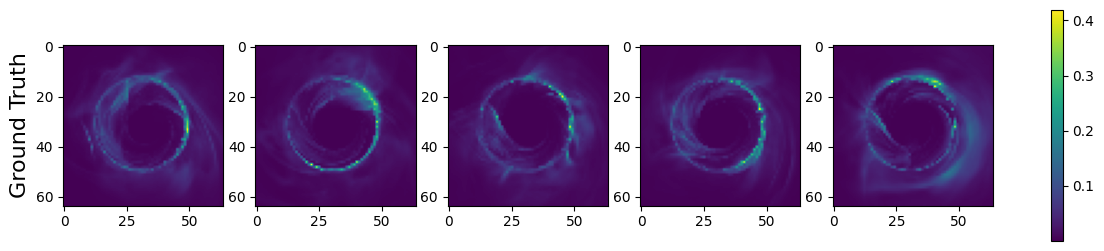

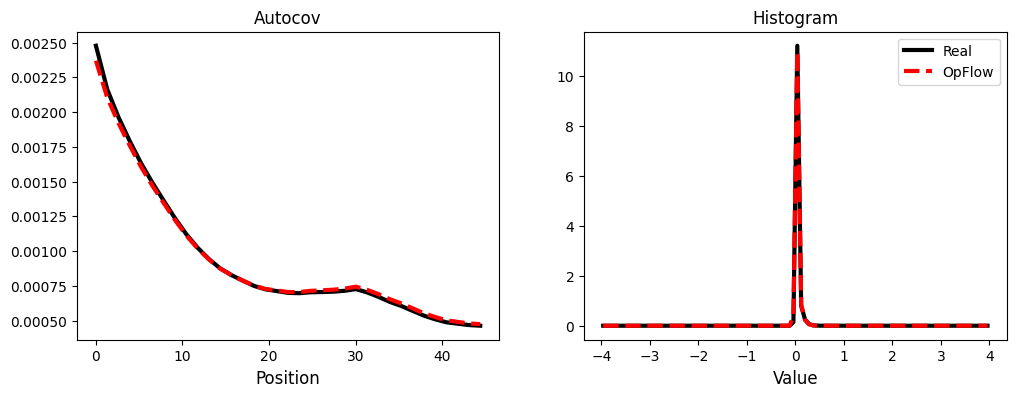

In [20]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(1):
        X_temp = fmot.sample([n_x, n_x], n_samples=400, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_train.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)

    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))

## 2D Regression

$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [9]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = 64
lr = 1e-3
epochs = 1000
noise_level = 0.001
 
# extract random observation from a test sample
berno_mask = torch.zeros((ndim, ndim))

mask_idx = np.random.choice(ndim*ndim, 32,replace=False)
berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(ndim,ndim)
pos_mask = (berno_mask == 1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[0:1,:]
u_obs_part = u_obs_full[:,:, pos_mask].to(device)

# generated noisy observation by injecting white noise
noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

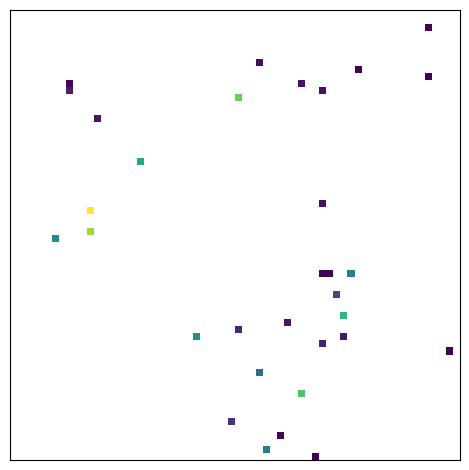

In [12]:
# plot the scatter 

fig, axs = plt.subplots(1,3)
add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern[0,0].detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt = u_obs_full[0].clone() + add_noise_plot

part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])
#plt.title('Partial Observation', fontsize=16)
plt.tight_layout()

#plt.savefig('./demo_figure.png', transparent=True)
plt.show()

In [13]:
G = fmot

# Get the MAP estimation (optional)

In [15]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        # take more time to average out
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True,n_repeat=8)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        loss1 = -0.5*torch.sum((u_obs_part.squeeze() - cur_u[:, pos_mask].squeeze() )**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [16]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [ ]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

## SGLD

In [40]:
"""
# empty cache to save GPU memory 
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary()) 
"""


'\n# for arius, memory constrain\nimport gc\ngc.collect()\ntorch.cuda.empty_cache()\nprint(torch.cuda.memory_summary()) \n'

In [20]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_992019/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [21]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True,n_repeat=8)
    loss1 = -0.5*torch.sum((u_obs_part - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [23]:
a_opflow_copy = x_test[0:1]

In [24]:
## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)

temperature = 1
momentum = 0

max_itr = int(2e4)
## should sample 6e4 to guarantee the smooth. 


langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [13:22:48<00:00,  2.41s/it]


In [25]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True).cpu().detach())
        
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 1, 64, 64])


In [ ]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [29]:
u_samples_all.shape

torch.Size([2000, 1, 64, 64])

In [30]:

## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]

sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

## Final Plots

In [77]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)


(4096, 2)


## Fit the best GP (optimized with MLE)

In [ ]:
## Fit the best GP
true_kernel = 0.5 * Matern(length_scale=0.1, length_scale_bounds=(1e-1, 0.5), nu=0.5)  + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-3, 0.05))

gpr = GaussianProcessRegressor(kernel=true_kernel, alpha=0)

gpr = gpr.fit(x_obs, y_obs) #update the GP model 

print(f"Initial: {true_kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: ")

In [80]:
# update the optimized parameter based on the above block, https://scikit-learn.org/1.5/modules/gaussian_process.html
true_kernel = 0.0412**2 * Matern(length_scale=0.5, nu=0.5)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=0.00167)

gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 


In [81]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(ndim,ndim)
y_std = y_std.reshape(ndim,ndim)
y_samples = gpr_model_ground_truth.sample_y(X, 1000).reshape(ndim,ndim,-1)

In [82]:
saved_folder = 'GRF2blackhole_OFM_sup'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

In [83]:
from matplotlib.colors import TwoSlopeNorm

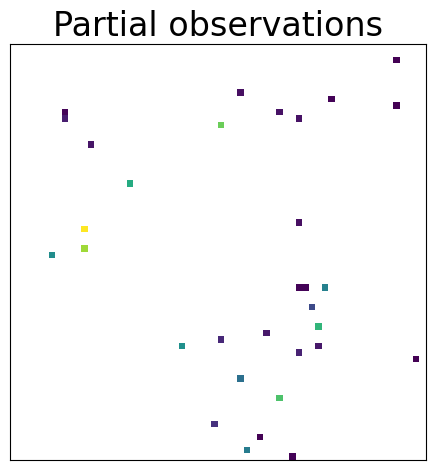

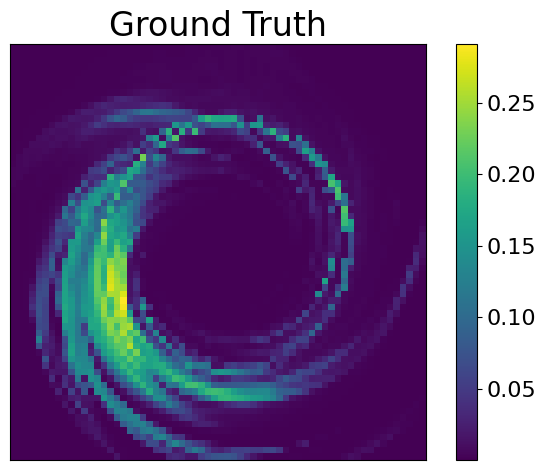

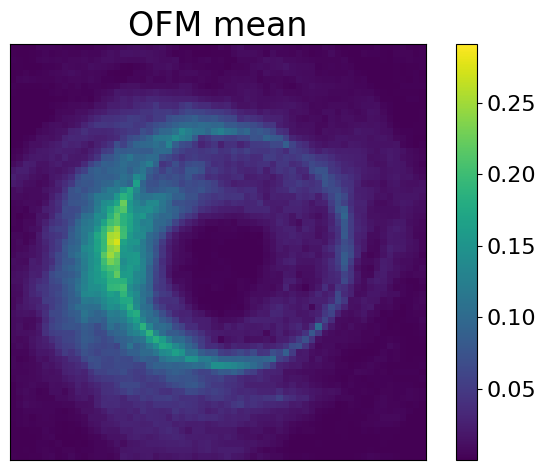

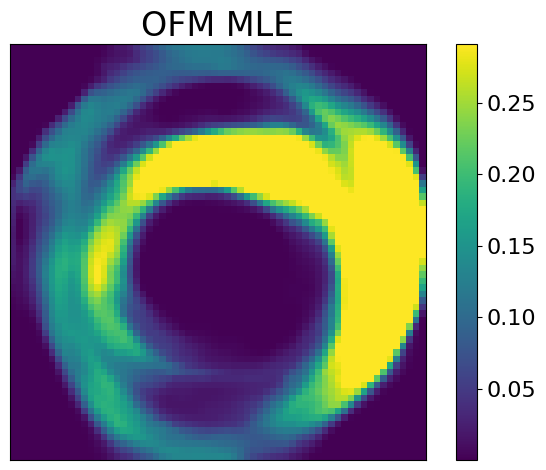

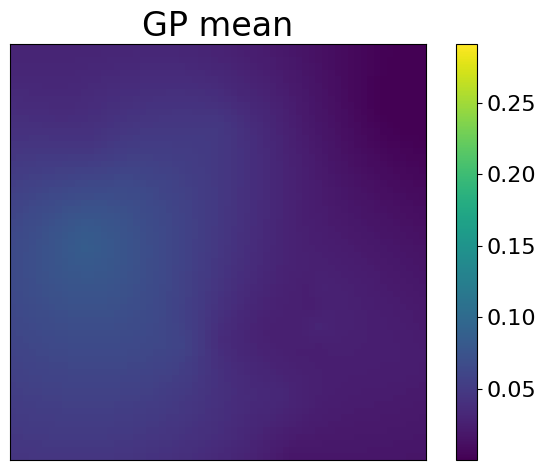

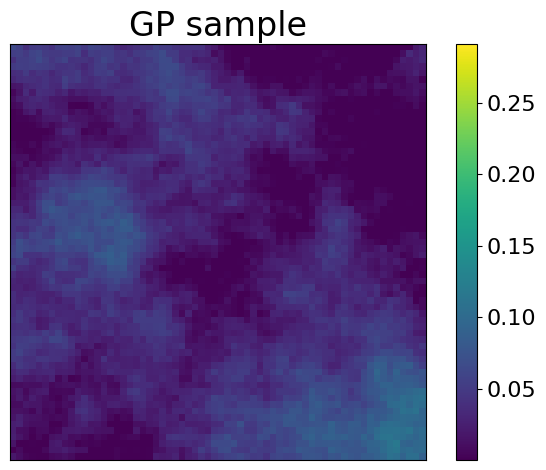

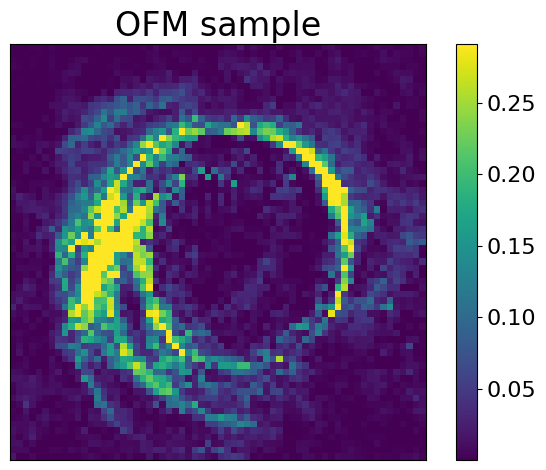

In [85]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(ndim,ndim)
y_std = y_std.reshape(ndim,ndim)
#y_samples = gpr_model_ground_truth.sample_y(X, 5000).reshape(32,32,-1)

### plot parameter
y_min_plot, y_max_plot = u_obs_full.min(), u_obs_full.max()

#y_abs_max = np.abs(y_mean).max()

#part_gt = u_obs_full.clone()
#part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observations', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_partial_obs_sup.pdf")


plt.figure()
plt.imshow(u_obs_full, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_gt_sup.pdf")


plt.figure()
plt.imshow(sample_mean, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_ofm_mean_sup.pdf")


plt.figure()
plt.imshow(u_opflow.clone().detach().cpu().squeeze(), alpha=0.8, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM MLE', fontsize=24)
plt.tight_layout() # not, because I initailly zero
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_ofm_MLE_sup.pdf")

plt.figure()
plt.imshow(y_mean, vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_gp_mean_sup.pdf")


plt.figure()
plt.imshow(y_samples[:,:,0], vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP sample', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_gp_sample_sup.pdf")

plt.figure()
plt.imshow(est_samples[380].squeeze(), vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM sample', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_ofm_sample_sup.pdf")

## Generate 3 representative scenarios

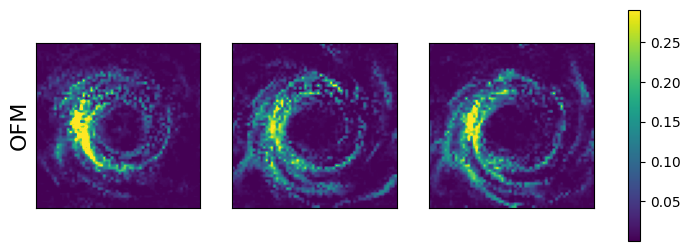

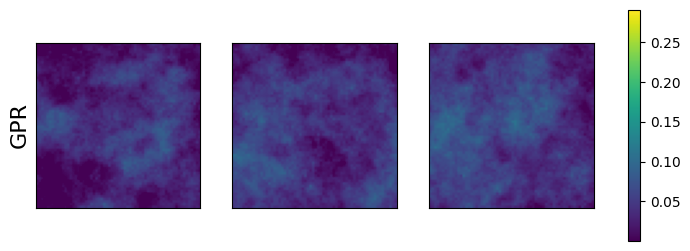

In [53]:
## each one generate 3 plots
## For the scenario, select 3 representative scenario for OpFlow and Ground Truth

random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OFM', fontsize=16)
        
bar = ax[2].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)    
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_scen_ofm_sup.pdf")

random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('GPR', fontsize=16)
        
bar = ax[2].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)   
plt.savefig(f"../Regression_results/{saved_folder}/bh_reg_scen_gt_sup.pdf")


## save the result

In [54]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()